In [7]:
import HelperFunctions
import mne
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import torch
from torch.utils.data import TensorDataset
from mne.event import define_target_events

parameters = {
    # data
    "data_path": "F:/Masterthesis",
    "task": "N170",
    "preprocessing": "light",
    "n_subjects": 40,
    "reject_incorrect_responses": False
}

In [8]:
def load_data(parameters):
    """
    Loads the ERP Core Data and returns a list of mne.Raw objects.
    """
    # get correct preprocessing file names
    if parameters["preprocessing"]=='light':
        preprocessing = "_shifted_ds_reref_ucbip.set"
    elif parameters["preprocessing"]=='medium':
        preprocessing = "_shifted_ds_reref_ucbip_hpfilt.set"
    elif parameters["preprocessing"]=='heavy':
        preprocessing = "_shifted_ds_reref_ucbip_hpfilt_ica_weighted.set"
    else:
        print("Wrong Preprocessing")    
    if parameters["task"]== "MMN":
        # cut shifted for MMN
        preprocessing = preprocessing[8:]
        
    # first create list of data paths, then read data with mne
    erp_core_paths = []    
    for i in range(1,parameters["n_subjects"]+1):
        erp_core_paths.append(parameters["data_path"] + "/"+parameters["task"]+"/"+str(i)+"/"+str(i)+"_"
                              +parameters["task"]+preprocessing)
    list_of_raws = [mne.io.read_raw_eeglab(path, preload=True) for path in erp_core_paths]
    
    return list_of_raws


def epoch_raws(list_of_raws, parameters):
    # TODO: This could be a bit cleaner.
    """
    Takes a list of mne.Raw objects, epochs them using the correct tmin, tmax, 
    and events for each task, and then returns a dataframe containing all epochs.
    """   
    # get correct tmin, tmax, and event mapping per task
    tmin = -0.2
    tmax = 0.8
    if parameters["task"] == "N170":
        # Cars: 0, Faces: 1
        custom_mapping = dict((str(i), 1) for i in range(0,41))
        custom_mapping.update(dict((str(i), 0) for i in range(41,81)))
    elif parameters["task"] == "N400":
        # unrelated word: 0, Related word: 1
        custom_mapping = {'221': 0, '222': 0, '211': 1, '212': 1} 
    elif parameters["task"] == "N2pc":
        # left: 0, right: 1
        custom_mapping = {'111': 0, '112': 0, '211': 0, '212': 0, 
                          '121': 1, '122': 1, '221': 1, '222': 1}
    elif parameters["task"] == "P3":
        # target=stimulus (rare): 0, target!=stimulus (frequent): 1
        custom_mapping = {'11': 0, '12': 1, '13': 1, '14': 1, '15': 1, 
                          '21': 1, '22': 0, '23': 1, '24': 1, '25': 1,
                          '31': 1, '32': 1, '33': 0, '34': 1, '35': 1,
                          '41': 1, '42': 1, '43': 1, '44': 0, '45': 1,
                          '51': 1, '52': 1, '53': 1, '54': 1, '55': 0}
    elif parameters["task"] == "MMN":
        # deviant: 0, standard: 1
        custom_mapping = {'70': 0, '80': 1}
    elif parameters["task"] == "ERN":
        # incorrect: 0, correct: 1
        custom_mapping = {'112': 0, '122': 0, '211': 0, '221': 0,
                          '111': 1, '121': 1, '212': 1, '222': 1}
        tmin = -0.6
        tmax = 0.4
    elif parameters["task"] == "LRP":
        # left response: 0, right response: 1
        custom_mapping = {'111': 0, '112': 0, '121': 0, '122': 0, 
                          '211': 1, '212': 1, '221': 1, '222': 1}
        tmin = -0.8
        tmax = 0.2

    # create list of epoch dataframes including all subjects
    list_of_epochs = []
    for i in range(0,parameters["n_subjects"]):
        # add responses
        if parameters["reject_incorrect_responses"] == True and parameters["task"] in ["N170", "N400", "N2pc", "P3"]:
            custom_mapping.update({'201': 201, '202': 202})


        (events_from_annot, event_dict) = mne.events_from_annotations(list_of_raws[i], 
                                                                      event_id=custom_mapping)
        # TODO: Sanity checks on incorrect responses
        # TODO: Sort event list after combining
        # only include events where response is in time and correct
        if parameters["reject_incorrect_responses"] == True and parameters["task"] in ["N170", "N400", "N2pc", "P3"]:
            events_0, lag_0 = define_target_events(events_from_annot, 0, 201, list_of_raws[0].info['sfreq'], 0, 0.8, 0, 999)
            events_1, lag_1 = define_target_events(events_from_annot, 1, 201, list_of_raws[0].info['sfreq'], 0, 0.8, 1, 999)
            events_from_annot = np.concatenate((events_0, events_1), axis=0)
            event_dict.pop("201")
            event_dict.pop("202")
        
        epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax, 
                           reject_by_annotation=False, baseline=(None,0), picks=range(0,28))
        epoch = epoch.to_data_frame()
        epoch["subjectID"]=i+1
        list_of_epochs.append(epoch)
        
    df_epochs = pd.concat(list_of_epochs, axis=0)
    
    # change condition naming to binary labels
    for condition in custom_mapping:
        df_epochs["condition"] = df_epochs["condition"].replace(condition,custom_mapping[condition])
        
    return df_epochs


def load_dataframe(parameters):
    # TODO: This might be better with df_epochs as an input instead of running load_data and epoch_raws
    """
    Loads data, epochs it, then reshapes the dataframe into data and labels.
    """
     # load data and epoch
    list_of_raws = load_data(parameters)
    df_epochs = epoch_raws(list_of_raws, parameters)
    
    # TODO: Get rid of fixed number for unique timepoints
    # reshape data
    data = df_epochs.iloc[:,3:31]
    #data = (df_epochs.iloc[:,3:31]-df_epochs.iloc[:,3:31].mean())/df_epochs.iloc[:,3:31].std()
    data = data.to_numpy().reshape(int(data.shape[0]/257), 257, -1)
    data = np.transpose(data,axes=[0,2,1])
    
    # create labels
    df = df_epochs[["epoch","condition","subjectID"]].drop_duplicates()
    df = df.reset_index()
    
    df["data"]=pd.Series(list(data))
    df = df.drop(columns=["index"])
    
    return df


def create_data_labels(df):
    """
    Takes dataframe and returns numpy versions of the data and labels. 
    """
    # get data from dataframe and reshape back
    data = np.dstack(df["data"].to_numpy())
    data = np.moveaxis(data, -1, 0)
    # get labels from dataframe
    labels = df["condition"].to_numpy()
    
    return data, labels


def create_dataset(df):
    """
    Takes dataframe and returns pytorch dataset. 
    """
    data, labels = create_data_labels(df)
    # create dataset
    dataset = TensorDataset(torch.from_numpy(data).float(),torch.from_numpy(labels).float())
    
    return dataset

In [9]:
df = load_dataframe(parameters)
data, labels = create_data_labels(df)

Reading F:\Masterthesis\N170\1\1_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 174847  =      0.000 ...   682.996 secs...
Reading F:\Masterthesis\N170\2\2_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 170751  =      0.000 ...   666.996 secs...
Reading F:\Masterthesis\N170\3\3_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 144895  =      0.000 ...   565.996 secs...
Reading F:\Masterthesis\N170\4\4_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 162303  =      0.000 ...   633.996 secs...
Reading F:\Masterthesis\N170\5\5_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 150783  =      0.000 ...   588.996 secs...
Reading F:\Masterthesis\N170\6\6_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 132351  =      0.000 ...   516.996 secs...
Reading F:\Masterthesis\N170\7\7_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 147455  =      0.000 ...   575.996 secs...
Reading F:\Masterthesis\N170\8\8_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 201215  =      0.000 ...   785.996 secs...
Reading F:\Masterthesis\

Not setting metadata
Not setting metadata
160 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 160 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
160 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 160 events and 2

Not setting metadata
Not setting metadata
160 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 160 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
160 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 160 events and 2

Not setting metadata
Not setting metadata
160 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 160 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
160 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 160 events and 2

Not setting metadata
Not setting metadata
160 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 160 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
160 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 160 events and 2

In [120]:
list_of_raws = load_data(parameters)
## take list of raws and load the epochs corresponding to the task
## returns dataframe of epochs
tmin = -0.2
tmax = 0.8
if parameters["task"] == "N170":
    # Cars: 0, Faces: 1
    custom_mapping = dict((str(i), 1) for i in range(0,41))
    custom_mapping.update(dict((str(i), 0) for i in range(41,81)))
elif parameters["task"] == "N400":
    # unrelated word: 0, Related word: 1
    custom_mapping = {'221': 0, '222': 0, '211': 1, '212': 1} 
elif parameters["task"] == "N2pc":
    # left: 0, right: 1
    custom_mapping = {'111': 0, '112': 0, '211': 0, '212': 0, 
                      '121': 1, '122': 1, '221': 1, '222': 1}
elif parameters["task"] == "P3":
    # target=stimulus (rare): 0, target!=stimulus (frequent): 1
    custom_mapping = {'11': 0, '12': 1, '13': 1, '14': 1, '15': 1, 
                      '21': 1, '22': 0, '23': 1, '24': 1, '25': 1,
                      '31': 1, '32': 1, '33': 0, '34': 1, '35': 1,
                      '41': 1, '42': 1, '43': 1, '44': 0, '45': 1,
                      '51': 1, '52': 1, '53': 1, '54': 1, '55': 0}
elif parameters["task"] == "MMN":
    # deviant: 0, standard: 1
    custom_mapping = {'70': 0, '80': 1}
elif parameters["task"] == "ERN":
    # incorrect: 0, correct: 1
    custom_mapping = {'112': 0, '122': 0, '211': 0, '221': 0,
                      '111': 1, '121': 1, '212': 1, '222': 1}
    tmin = -0.6
    tmax = 0.4
elif parameters["task"] == "LRP":
    # left response: 0, right response: 1
    custom_mapping = {'111': 0, '112': 0, '121': 0, '122': 0, 
                      '211': 1, '212': 1, '221': 1, '222': 1}
    tmin = -0.8
    tmax = 0.2

list_of_epochs = []
for i in range(0,parameters["n_subjects"]):
    # add responses
    if parameters["reject_incorrect_responses"] == True and parameters["task"] in ["N170", "N400", "N2pc", "P3"]:
        custom_mapping.update({'201': 201, '202': 202})


    (events_from_annot, event_dict) = mne.events_from_annotations(list_of_raws[i], 
                                                                  event_id=custom_mapping)
    # only include events where response is in time and correct
    if parameters["reject_incorrect_responses"] == True and parameters["task"] in ["N170", "N400", "N2pc", "P3"]:
        events_0, lag_0 = define_target_events(events_from_annot, 0, 201, list_of_raws[0].info['sfreq'], 0, 0.8, 0, 999)
        events_1, lag_1 = define_target_events(events_from_annot, 1, 201, list_of_raws[0].info['sfreq'], 0, 0.8, 1, 999)
        events_from_annot = np.concatenate((events_0, events_1), axis=0)
        event_dict.pop("201")
        event_dict.pop("202")

    epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax, 
                       reject_by_annotation=True, baseline=(None,0), picks=range(0,28))
    epoch = epoch.to_data_frame()
    epoch["subjectID"]=i+1
    list_of_epochs.append(epoch)

df_epochs = pd.concat(list_of_epochs, axis=0)
for condition in custom_mapping:
    df_epochs["condition"] = df_epochs["condition"].replace(condition,custom_mapping[condition])


Reading F:\Masterthesis\N170\1\1_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 174847  =      0.000 ...   682.996 secs...
Reading F:\Masterthesis\N170\2\2_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 170751  =      0.000 ...   666.996 secs...
Reading F:\Masterthesis\N170\3\3_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 144895  =      0.000 ...   565.996 secs...
Reading F:\Masterthesis\N170\4\4_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 162303  =      0.000 ...   633.996 secs...
Reading F:\Masterthesis\N170\5\5_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 150783  =      0.000 ...   588.996 secs...
Reading F:\Masterthesis\N170\6\6_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 132351  =      0.000 ...   516.996 secs...
Reading F:\Masterthesis\N170\7\7_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 147455  =      0.000 ...   575.996 secs...
Reading F:\Masterthesis\N170\8\8_N170_shifted_ds_reref_ucbip.fdt
Reading 0 ... 201215  =      0.000 ...   785.996 secs...
Reading F:\Masterthesis\

<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 149 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
157 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 157 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '1

<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
156 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 156 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '3

<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
149 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 149 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '3

<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
157 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 157 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '3

<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
154 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 154 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
148 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 148 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
140 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 140 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 154 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
157 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 157 events and 257 original time points ...
0 bad epochs dropped
Used 

<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '9']
Not setting metadata
Not setting metadata
148 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 148 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34',

<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,
<ipython-input-120-2b312ec9abdb>:57: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epoch = mne.Epochs(list_of_raws[i], events_from_annot, event_dict,tmin=tmin,tmax=tmax,


In [10]:
df

,epoch,condition,subjectID,data
0,0,0,1,"[[15.99355844350992, 16.155179537259528, 15.33..."
1,1,0,1,"[[-9.12572303185099, -10.943105844350882, -10...."
2,2,0,1,"[[-0.8858642578128337, 0.6873779296876283, 1.7..."
3,3,1,1,"[[5.624455378605564, 3.270939753606192, 2.1054..."
4,4,1,1,"[[-6.111985426683446, -7.245286207933563, -7.7..."
...,...,...,...,...
6395,155,0,40,"[[-8.125260573167042, -11.814469557542065, -15..."
6396,156,1,40,"[[2.166989839993993, -2.830446683443487, -6.47..."
6397,157,0,40,"[[-5.650353064903758, -9.577599158653769, -4.7..."
6398,158,1,40,"[[1.7571129432092185, -1.7120032677282782, -5...."


In [5]:
df["condition"].value_counts()

1    2930
0    2869
Name: condition, dtype: int64

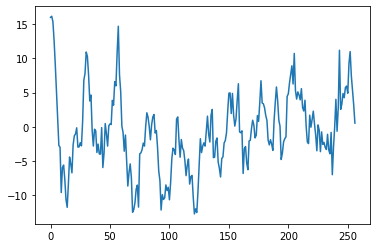

In [6]:
plt.plot(df["data"][0][0])

# Testing Learning

In [32]:
dataset = load_dataset(data_path, "N2pc", "_shifted_ds_reref_ucbip.set", number_of_subjects)

Reading F:\Masterthesis\N2pc\1\1_N2pc_shifted_ds_reref_ucbip.fdt
Reading 0 ... 203007  =      0.000 ...   792.996 secs...
Reading F:\Masterthesis\N2pc\2\2_N2pc_shifted_ds_reref_ucbip.fdt
Reading 0 ... 203263  =      0.000 ...   793.996 secs...
Reading F:\Masterthesis\N2pc\3\3_N2pc_shifted_ds_reref_ucbip.fdt
Reading 0 ... 153599  =      0.000 ...   599.996 secs...
Reading F:\Masterthesis\N2pc\4\4_N2pc_shifted_ds_reref_ucbip.fdt
Reading 0 ... 152063  =      0.000 ...   593.996 secs...
Reading F:\Masterthesis\N2pc\5\5_N2pc_shifted_ds_reref_ucbip.fdt
Reading 0 ... 168191  =      0.000 ...   656.996 secs...
Reading F:\Masterthesis\N2pc\6\6_N2pc_shifted_ds_reref_ucbip.fdt
Reading 0 ... 135423  =      0.000 ...   528.996 secs...
Reading F:\Masterthesis\N2pc\7\7_N2pc_shifted_ds_reref_ucbip.fdt
Reading 0 ... 154623  =      0.000 ...   603.996 secs...
Reading F:\Masterthesis\N2pc\8\8_N2pc_shifted_ds_reref_ucbip.fdt
Reading 0 ... 156671  =      0.000 ...   611.996 secs...
Reading F:\Masterthesis\

Not setting metadata
Not setting metadata
320 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 320 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['111', '112', '121', '122', '211', '212', '221', '222']
Not setting metadata
Not setting metadata
330 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 330 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['111', '112', '121', '122', '211', '212', '221', '222']
Not setting metadata
Not setting metadata
320 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 320 events and 257 original time points ...
0 bad epochs dropped
Used 

0 bad epochs dropped
Used Annotations descriptions: ['111', '112', '121', '122', '211', '212', '221', '222']
Not setting metadata
Not setting metadata
320 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 320 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['111', '112', '121', '122', '211', '212', '221', '222']
Not setting metadata
Not setting metadata
320 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 320 events and 257 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['111', '112', '121', '122', '211', '212', '221', '222']
Not setting metadata
Not setting metadata
320 matching events found
Setting baseline interval to [-0.19921875, 0.0] sec
Applying baseline correction (mode: mean)
0 proje

In [8]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet, EEGNetv1

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to reproduce results
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2
n_chans = 28
input_window_samples = 257

model = EEGNetv1(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()

C:\Users\vapor\anaconda3\envs\braindecode\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
from skorch.callbacks import LRScheduler
from skorch.dataset import CVSplit
from braindecode import EEGClassifier

lr = 0.01
weight_decay = 0


batch_size = 64
n_epochs = 30

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=CVSplit(cv=0.2, stratified=False),
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=["accuracy"],
    device=device,
)

clf.fit(dataset, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss     dur
-------  ----------------  ------------  ----------------  ------------  ------
      1            0.9136        0.3144            0.9146        0.2331  3.6412
      2            0.9255        0.2235            0.9206        0.2162  3.1276
      3            0.9266        0.2051            0.9290        0.2027  3.0598
      4            0.9373        0.1926            0.9305        0.2012  3.0639
      5            0.9361        0.1919            0.9336        0.1937  3.0668
      6            0.9393        0.1808            0.9346        0.1919  3.0658
      7            0.9337        0.1785            0.9324        0.1906  3.1373
      8            0.9438        0.1817            0.9364        0.1802  3.1340
      9            0.9341        0.1766            0.9330        0.1921  3.0628
     10            0.9424        0.1723            0.9358        0.1830  3.0684
     11            0.9405        0.1686 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=EEGNetv1(
    (ensuredims): Ensure4d()
    (conv_1): Conv2d(28, 16, kernel_size=(1, 1), stride=(1, 1))
    (bnorm_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (elu_1): Expression(expression=elu) 
    (permute_1): Expression(expression=<lambda>) 
    (drop_1): Dropout(p=0.25, inplace=False)
    (conv_2): Conv2d(1, 4, kernel_size=(2, 32), stride=(1, 1), padding=(1, 0))
    (bnorm_2): BatchNorm2d(4, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (elu_2): Expression(expression=elu) 
    (pool_2): MaxPool2d(kernel_size=(2, 4), stride=(2, 4), padding=0, dilation=1, ceil_mode=False)
    (drop_2): Dropout(p=0.25, inplace=False)
    (conv_3): Conv2d(4, 4, kernel_size=(8, 4), stride=(1, 1), padding=(4, 0))
    (bnorm_3): BatchNorm2d(4, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (elu_3): Expression(expression=elu) 
    (pool_3): MaxPool